In [2]:
import sys
import numpy as np
from numpy import matrix
#import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
#import triangle
import random,os
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy.table import Table
from astropy.table import Column
from astropy.table import join
c = 300000. # km/sec
q=-0.59 # decelertion parameter
%matplotlib inline
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

/Users/suddin/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/gw/w6qdd1bn6zb2zrvd6dz7_9400000gp/T/matplotlib-lfzteo8f because there was an issue with the default path (/Users/suddin/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
dyld[24531]: symbol '_CGLSetCurrentContext' missing from root that overrides /System/Library/Frameworks/OpenGL.framework/Versions/A/Libraries/libGL.dylib. Use of that symbol in /System/Library/Frameworks/OpenGL.framework/Versions/A/OpenGL is being set to 0xBAD4007.
dyld[24531]: symbol '_CGLGetCurrentContext' missing from root that overrides /System/Library/Frameworks/OpenGL.framework/Versions/A/Libraries/libGL.dylib. Use of that symbol in /System/Library/Frameworks/OpenGL.framework/Versions/A/OpenGL is being set to 0xBAD4007.
dyld[24531]: symbol '_gll_noop' 

In [3]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + ((1-q)*z1/2)
    return (5*np.log10(t1*t2*t3)) +25


9 15
14 22
9 16
12 24
13 21
12 21
12 14
14 14
10 14


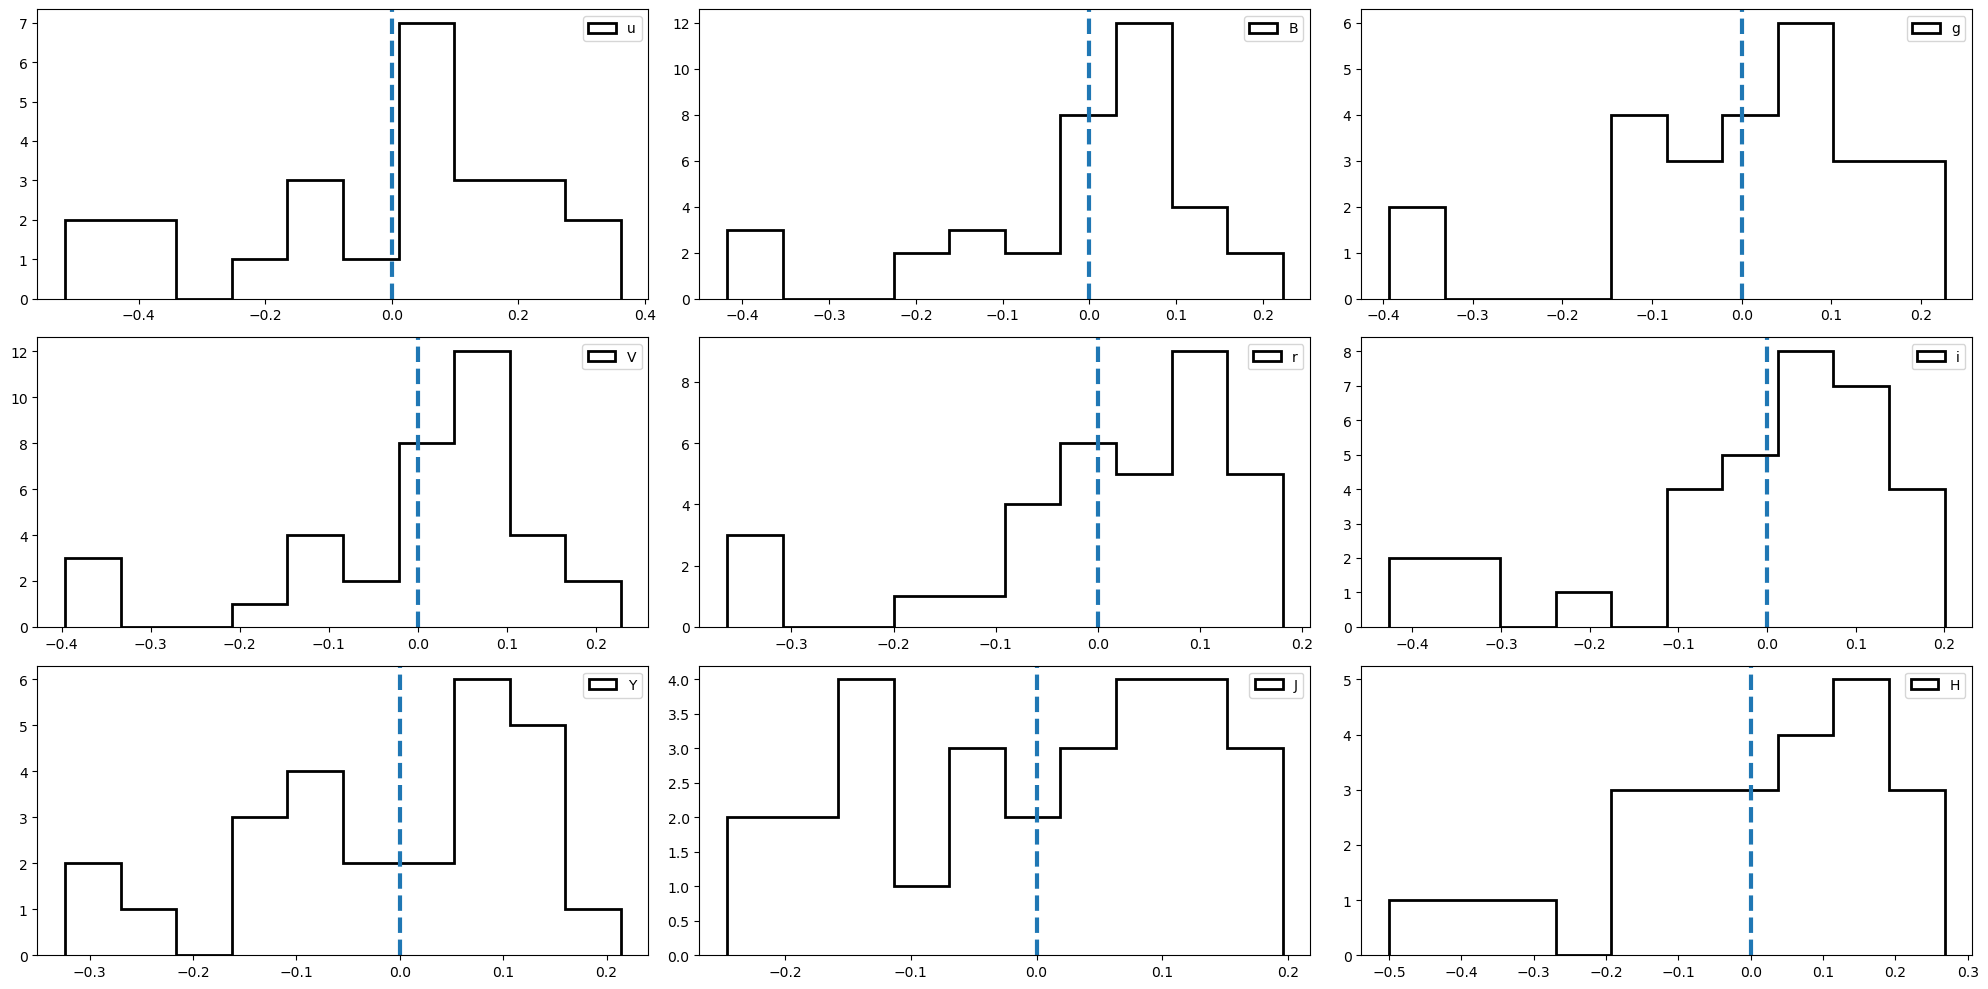

In [23]:
# Getting results
pl.figure(figsize=(20,10))
filter = ['u','B','g','V','r','i','Y','J','H']

#filter=['B','H']s
for i in range(len(filter)):
    mu_obs=[]
    mu_model=[]
    mu_stat=[]
    dmu_sn =[]
    dmu_cal=[]

    result = ascii.read('../results/trippmethod/'+filter[i]+'_sbfj21_update3_result_tripp.txt')
    #result = ascii.read('../../results/B_trgb_result.txt')
    p=result['p0'][0]
    ep = (result['p0'][1]+result['p0'][2])/2
    p1=result['p1'][0]
    ep1 = (result['p1'][1]+result['p1'][2])/2
    p2=result['p2'][0]
    ep2 = (result['p2'][1]+result['p2'][2])/2
    
    rv=result['beta'][0]
    erv = (result['beta'][1]+result['beta'][2])/2
    sig=result['sig_int'][0]
    
    h0=result['H0'][0]
    eh0 = (result['H0'][1]+result['H0'][2])/2

    #ep2=ep2/10.


    tab = ascii.read('../data/working/'+filter[i]+'_sbfj21_update3.csv')
    if not 'SN2011iv' in tab['sn']:
    
    #B
        tab.add_row({'sn':'SN2011iv','dist':31.453,'edist':0.084, 'st':0.699,'est':0.007,'Mmax':12.78, 'eMmax': 0.008,'covMs':1.171e-05,'covBV_M':6.4e-05 })
    #H
    #tab.add_row({'sn':'SN2011iv', 'st':0.699,'est':0.007,'Mmax':12.78, 'eMmax': 0.033,'covMs':-3.753e-05,'covBV_M':0.0 })


#if not 'SN20016ajf' in tab['sn']: ## on g-band 
 #       tab.add_row({'sn':'SN2016ajf', 'st':0.493,'est':0.016,'Mmax':16.367, 'eMmax': 0.057, 'covMs':0.0,'covBV_M':0.0 })

    st = tab['st']
    est = tab['est']
    zhel = tab['zhel']
    zcmb = tab['zcmb']
    mmax = tab['Mmax']
    emmax = tab['eMmax']
    bv = tab['BV']
    ebv = tab['eBV']
    
    dist = tab['dist']
    edist = tab['edist']
    c_ms = tab['covMs']
    c_mbv = tab['covBV_M']
    sn = tab['sn']
    ebv_host = tab['EBVmw']
# change SNhunt281

#adding more calibrators from Garnavich 2023
#1
    c1 = np.where(sn =='SN2006mr') #31.200 ± 0.093
    dist[c1]=31.2
    edist[c1]=0.093
#print(sn[c1],dist[c1])
#2
    c2 = np.where(sn =='SN2007on') # 31.453 ± 0.084
    dist[c2]=31.453
    edist[c2]=0.084
#print(sn[c2],dist[c2])
#3
    c3 = np.where(sn =='SNhunt281')# 32.369,0.078 same as SN2015bp from Jensen 2021
    dist[c3]=32.369
    edist[c3]=0.078
#print(sn[c3],dist[c3])

# #4
    c4 = np.where(sn =='SN2011iv')# # 31.453 ± 0.084
    dist[c4]=31.453
    edist[c4]=0.084
# print(sn[c4],dist[c4])
# #4
    c5 = np.where(sn =='SN2016ajf')# # 31.453 ± 0.084
    dist[c5]=34.202
    edist[c5]=0.106
# print(sn[c4],dist[c4])
    supernovae = Column([
    "SN2005bl", "SN2006bd", "SN2006gt", "SN2006ob", "SN2007al",
    "SN2007mm", "SN2007ol", "SN2007ux", "SN2008R", "SN2009F",
    "CSP13aao", "KISS15m", "LSQ11pn", "LSQ12fvl", "LSQ13dkp",
    "LSQ14act", "LSQ14ajn", "LSQ14ip", "LSQ14jp", "PTF13ebh",
    "PTF14w", "SN2011jn", "SN2012ij", "SN2013ay"
], name="Supernovae")
    w0=[]

    supernova_array = np.array(supernovae)
    new_array = np.array(sn)

# Find indices of matching entries from supernova_column in new_column
    match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in supernova_array])

    for name, idx in zip(supernova_array, match):
        if idx != -1:
            #print(f"{name} found at index {idx} in new_column")
        
            w0.append(idx)
        else:
            pass
        #print(f"{name} not found in new_column")
    ## Calibrators B          
    calibrators = Column([
        "SN2007cv",
        "SN2008hs",
        "SN2010Y",
        "SN2014bv",
        "SN2016ajf",
        "SN2006mr",
        "SN2007on",
        "SN2008R",
        "SN2011iv",
        "PTF13ebh",
        "CSP15aae",
        "SNhunt281"
    ],name='Calibrators') 




    w1=[]

    calibrators_array = np.array(calibrators)

# Find indices of matching entries from supernova_column in new_column
    match = np.array([np.where(new_array == name)[0][0] if name in new_array else -1 for name in calibrators_array])

    for name, idx in zip(calibrators_array, match):
        if idx != -1:
            #print(f"{name} found at index {idx} in new_column")
        
            w1.append(idx)
        else:
            pass
            #print(f"{name} not found in new_column")
         


    #print (len(st[w0]),len(st[w1]))
    mu_sn = mmax[w0] - p - p1*(st[w0] - 0.5) -  p2*(st[w0] - 0.5)**2 - rv*(bv[w0]-0.4) #- alpha*(m_csp[w0]-np.median(m_csp[w0]))

    mu_cal = mmax[w1] - p - p1*(st[w1] - 0.5) -  p2*(st[w1] - 0.5)**2 - rv*(bv[w1]-0.4) #- alpha*(m_csp[w1]-np.median(m_csp[w1]))
        
    for mu_sn in mu_sn:
        mu_obs.append(mu_sn)
    for mu_cal in mu_cal:
        mu_obs.append(mu_cal)
        
    mu_model_sn = distmod(h0,zhel[w0],zcmb[w0])
    mu_model_cal = dist[w1]
    
    for mu_model_sn in mu_model_sn:
        mu_model.append(mu_model_sn)
    for mu_model_cal in mu_model_cal:
        mu_model.append(mu_model_cal)
        
    mu_obs = np.array(mu_obs)
    mu_model =np.array(mu_model)
    dmu = mu_obs-mu_model

    wl = np.where(dmu<0)
    wh = np.where(dmu>0)
    
    print(len(dmu[wl]), len(dmu[wh]))
    pl.subplot(3,3,i+1)
    pl.hist(dmu,histtype='step',color='k',label=filter[i],linewidth=2)
    pl.legend()
    pl.axvline(0,lw=3,ls='--')
pl.tight_layout()        
pl.savefig('../results/hist_hr_sbfj21_trippmethod.pdf')
